In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
!pip install torchinfo opendatasets wandb munch transformers --upgrade --quiet

In [6]:
import random
import cv2
import numpy as np
import pandas as pd
import os
import time
import copy
import opendatasets as od
import torch
import torch.nn as nn
import torchvision

from PIL import Image
from transformers import ViTModel, ViTConfig
from torchvision import transforms
from torch import optim
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
from scipy.io import loadmat
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
# model_checkpoint = 'google/vit-base-patch16-224-in21k'

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [7]:
NUMWORKERS = os.cpu_count()
IMG_SIZE = 224
IMAGE_CHANNELS = 3
NUM_CLASSES = 196
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
SCALE = 1.1
BATCHSIZE=16

#DIR CONFIGS
DATA_PATH = Path('/kaggle/input/stanford-cars-dataset')
META_PATH = Path(os.path.join(DATA_PATH,"car_devkit","devkit"))
CARS_TRAIN_PATH = Path(os.path.join(DATA_PATH,"cars_train","cars_train"))
CARS_TEST_PATH = Path(os.path.join(DATA_PATH,"cars_test","cars_test"))

# PRETRAINED = 'google/vit-large-patch16-224-in21k'
# HIDDEN_STATE = 1024

# PRETRAINED = 'google/vit-base-patch16-224'
# HIDDEN_STATE =  768

# PRETRAINED = 'google/vit-base-patch16-384'
# HIDDEN_STATE =  768 

In [8]:
def set_seeds(TORCH_SEED: int) -> None:
    """
    Sets the manual SEED
    """
    random.seed(TORCH_SEED)
    np.random.seed(TORCH_SEED)
    torch.manual_seed(TORCH_SEED)
    torch.cuda.manual_seed_all(TORCH_SEED)
    os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device() -> str:
    """
    Returns the default device available
    """
    return "cuda" if torch.cuda.is_available() else "cpu"

def denormalize(images, means=IMAGENET_MEAN, stds=IMAGENET_STD,device=get_device()):
    """
    Returns the denormalized image.
    """
    means = torch.tensor(means).reshape(1, 3, 1, 1).to(device)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1).to(device)
    return (images * stds + means)

Data

The data is analyzed in this notebook

In [9]:
class DefaultDataset(Dataset):
    def __init__(self, data_df,
                 transform = None,
                 is_test: bool = False):
        self.data_df = data_df
        self.is_test = is_test
        self.transform = transform

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        # Get image details
        img_details = self.data_df.iloc[idx]

        img_path = img_details["file_path"]
        # image = cv2.imread(img_path)
        # img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.open(img_path)
        img = image.convert("RGB")

        if self.transform:
            img = self.transform(img).to(torch.float)
        else:
            transform = transforms.ToTensor()
            img = transform(img).to(torch.float)

        if self.is_test:
            return img
        else:
            class_label = torch.tensor(img_details["class_idx"], dtype=torch.long)
            return (img, class_label)

def get_transforms(type):
    if type == 'train':
        train_transform = transforms.Compose([
            transforms.Resize((int(IMG_SIZE * SCALE),
                               int(IMG_SIZE * SCALE))),
            transforms.RandomResizedCrop(IMG_SIZE),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN,
                                 std=IMAGENET_STD)
        ])
        return train_transform

    elif type == 'test':
        val_test_transform = transforms.Compose([
            transforms.Resize(int(IMG_SIZE * SCALE)),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN,
                                 std=IMAGENET_STD)
        ])
        return val_test_transform

def create_train_df(labels):
    cars_train_annos = loadmat(Path(META_PATH) / 'cars_train_annos.mat')
    train_data = [[val.flat[0] for val in line] for line in cars_train_annos["annotations"][0]]
    columns = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class_idx", "fname"]
    train_df = pd.DataFrame(train_data, columns=columns)
    train_df["class_idx"] = train_df["class_idx"] - 1
    train_df = train_df.merge(labels, left_on='class_idx', right_index=True)
    func = lambda x: os.path.join(CARS_TRAIN_PATH, x)
    train_df["file_path"] = train_df["fname"].apply(func)
    return train_df

def create_test_df():
    cars_test_annos = loadmat(Path(META_PATH) / 'cars_test_annos.mat')
    test_data = [[val.flat[0] for val in line] for line in cars_test_annos["annotations"][0]]
    columns = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "fname"]
    test_df = pd.DataFrame(test_data, columns=columns)
    func = lambda x: os.path.join(CARS_TEST_PATH, x)
    test_df["file_path"] = test_df["fname"].apply(func)
    return test_df

def create_labels():
    cars_meta = loadmat(Path(META_PATH) / 'cars_meta.mat')
    labels = [car for car in cars_meta["class_names"][0]]
    labels = pd.DataFrame(labels, columns=["class_labels"])
    labels['class_labels'] = labels['class_labels'].str.replace(' ', '_')
    return labels

def get_data():
    labels = create_labels()
    train_df = create_train_df(labels)
    test_df = create_test_df()
    train_df, val_df = train_test_split(
        train_df,
        train_size=0.8,
        random_state=42,
        stratify=train_df["class_idx"]
    )
    return train_df, val_df, test_df

def create_dataloaders(train_df: pd.DataFrame,
                       val_df: pd.DataFrame,
                       test_df: pd.DataFrame):
    train_transform = get_transforms("train")
    val_test_transform = get_transforms("test")

    # Create the training, validation, and test datasets using the appropriate transforms
    train_dataset = DefaultDataset(data_df=train_df, transform=train_transform, is_test=False)
    val_dataset = DefaultDataset(data_df=val_df, transform=val_test_transform, is_test=False)
    test_dataset = DefaultDataset(data_df=test_df, transform=val_test_transform, is_test=True)

    # Create the training, validation, and test dataloaders using the appropriate datasets and batch size
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=BATCHSIZE,
        shuffle=True,
        num_workers=NUMWORKERS,
        pin_memory=True
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=BATCHSIZE,
        shuffle=False,  # Do not shuffle the data
        num_workers=NUMWORKERS,
        pin_memory=True
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=BATCHSIZE * 2,
        shuffle=False,  # Do not shuffle the data
        num_workers=NUMWORKERS,
        pin_memory=True
    )

    return train_dataloader, val_dataloader, test_dataloader

In [10]:
train_df, val_df, test_df = get_data()
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(train_df, val_df, test_df)

Model

In [11]:
# class ViT(nn.Module):
#     def __init__(self, config=ViTConfig(),
#                num_classes=NUM_CLASSES,
#                model_checkpoint=PRETRAINED):

#         super(ViT, self).__init__()

#         self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
#         for param in self.vit.parameters():
#             param.requires_grad = False
#         self.classifier =  nn.Sequential(
#             nn.Linear(HIDDEN_STATE, out_features=num_classes))
# #             nn.ReLU(inplace=True),
# #             nn.Dropout(p=0.1),
# #             nn.Linear(in_features=512, out_features=num_classes)
# #         )
        
#         self.initialize_weights()

#     def forward(self, x):
#         x = self.vit(x)['last_hidden_state']
#         # Use the embedding of [CLS] token
#         output = self.classifier(x[:, 0, :])
#         return output

#     def initialize_weights(self):
#         # Initialize the classifier weights using Xavier uniform distribution
#         for module in self.classifier.modules():
#             if isinstance(module, nn.Linear):
#                 nn.init.xavier_uniform_(module.weight)
#                 if module.bias is not None:
#                     nn.init.constant_(module.bias, 0)

In [12]:
class VehicleImageClassfier(nn.Module):
    def __init__(
        self,
        image_channels: int = IMAGE_CHANNELS,
        num_classes: int = NUM_CLASSES,
        num_layers: int = 50
    ):

        super(VehicleImageClassfier,self).__init__()

        self.image_channels = image_channels
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.classification_model = self.get_backbone()

        self.classification_model.fc = nn.Sequential(
            #nn.Linear(in_features=1* 1* self.in_features, out_features=1 * 1 * self.in_features//2),
            nn.Linear(in_features=1* 1* self.in_features, out_features=num_classes)
            # nn.ReLU(),
            # # nn.Linear(in_features=1 * 1 * self.in_features//2,out_features=1 * 1 * self.in_features),
            # nn.Dropout(p=0.3),#inplace=True),
            # nn.Linear(in_features=512, out_features=num_classes)
            #nn.Linear(in_features=1 * 1 * self.in_features, out_features=num_classes)
        )
    def forward(self,x):
        y_classification = self.classification_model(x)
        return y_classification

    def get_backbone(self):
        weights = torchvision.models.ResNet50_Weights
        pretrained_model = torchvision.models.resnet50(weights=weights)
        self.in_features = pretrained_model.fc.in_features

#         for param in pretrained_model.parameters():
#             param.requires_grad = False
        return pretrained_model
    
    def initialize_weights(self):
        # Initialize the classifier weights using Xavier uniform distribution
        for module in self.classification_model.fc.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

In [13]:
model= VehicleImageClassfier()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 49.4MB/s]


In [14]:
from torchinfo import summary

summary(model,
        input_size=(16, 3, IMG_SIZE, IMG_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
VehicleImageClassfier (VehicleImageClassfier)      [16, 3, 224, 224] [16, 196]       --              True
├─ResNet (classification_model)                    [16, 3, 224, 224] [16, 196]       --              True
│    └─Conv2d (conv1)                              [16, 3, 224, 224] [16, 64, 112, 112] 9,408           True
│    └─BatchNorm2d (bn1)                           [16, 64, 112, 112] [16, 64, 112, 112] 128             True
│    └─ReLU (relu)                                 [16, 64, 112, 112] [16, 64, 112, 112] --              --
│    └─MaxPool2d (maxpool)                         [16, 64, 112, 112] [16, 64, 56, 56] --              --
│    └─Sequential (layer1)                         [16, 64, 56, 56] [16, 256, 56, 56] --              True
│    │    └─Bottleneck (0)                         [16, 64, 56, 56] [16, 256, 56, 56] 75,008          True
│    │    └─Bottleneck (1)      

Model Performance before training

In [15]:
def evaluate_batch(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    return accuracy, precision, recall

In [16]:
def evaluate(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              criterion: torch.nn.Module):
    model.eval()
    device = get_device()
    test_loss, test_acc, test_precision, test_recall = 0, 0, 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = criterion(test_pred_logits, y)
            test_loss += loss.item()

            #Calculate and accumulate accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            batch_acc,batch_precision,batch_recall = evaluate_batch(y,test_pred_labels)

            test_acc += batch_acc
            test_precision += batch_precision
            test_recall += batch_recall

    # Calculate average metrics per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    test_precision = test_precision / len(dataloader)
    test_recall = test_recall / len(dataloader)

    return test_loss, test_acc, test_precision, test_recall

In [17]:
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, test_precision, test_recall = evaluate(model,val_dataloader,criterion)

test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f'''                         Metrics before training
 val_loss: {test_loss:.4f} | val_acc: {test_acc:.4f} | val_f1_score: {test_f1_score:.4f} ''')

                         Metrics before training
 val_loss: 5.3216 | val_acc: 0.0037 | val_f1_score: 0.0017 


predict a single image before training

In [18]:
labels = create_labels()

def predict(img_path,model):
    device = get_device()
    transform = get_transforms('test')
    img = Image.open(img_path)
    img = transform(img)
    output = model(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return labels.iloc[prediction]

In [19]:
sample = val_df.sample()
sample

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_idx,fname,class_labels,file_path
5567,207,256,971,832,29,05568.jpg,BMW_3_Series_Wagon_2012,/kaggle/input/stanford-cars-dataset/cars_train...


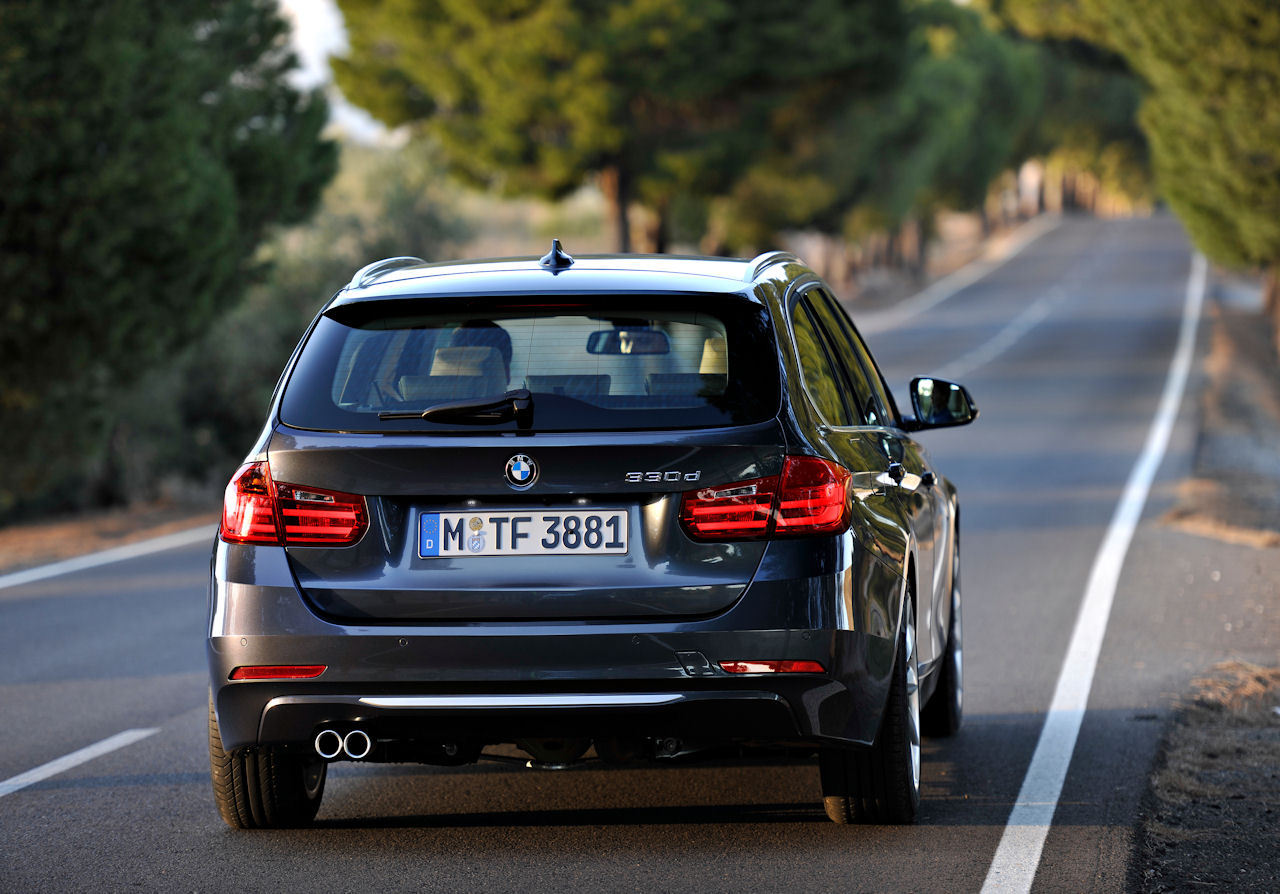

In [20]:
img = Image.open(sample['file_path'].item())
img

In [21]:
labels.iloc[sample['class_idx'].item()]

class_labels    BMW_3_Series_Wagon_2012
Name: 29, dtype: object

prediction

In [22]:
predict(sample['file_path'].item(),model)

class_labels    Acura_RL_Sedan_2012
Name: 1, dtype: object

Model Training

In [23]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [24]:
def save_model(model_save_path, model,optimizer,epoch,avg_metrics):
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(
            {
                'epoch': epoch,
                'average_metrics': avg_metrics,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            },
            f=model_save_path
        )

In [25]:
def train_model(model,train_dataloader,test_dataloader,config):
    device = get_device()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(),lr=config.learning_rate,weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    wandb.init(project=config.project,name=config.experiment_name,config=config)

    for epoch in tqdm(range(config.start_iter,config.epochs)):

        model.train()
        train_loss, train_acc, train_precision, train_recall = 0, 0, 0, 0
        for  (X, y) in (train_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss = criterion(y_pred, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()

            if config.grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), config.grad_clip)
            optimizer.step()

            with torch.no_grad():
                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                batch_acc,batch_precision,batch_recall = evaluate_batch(y,y_pred_class)

                train_acc += batch_acc
                train_precision += batch_precision
                train_recall += batch_recall
        
        # calculate avg metrics per batch
        avg_metrics = OrderedDict()
        avg_metrics['lr'] = optimizer.param_groups[0]['lr']
        avg_metrics['train_loss'] = train_loss / len(train_dataloader)
        avg_metrics['train_acc'] = train_acc / len(train_dataloader)
        avg_metrics['train_precision'] = train_precision/ len(train_dataloader)
        avg_metrics['train_recall'] = train_recall/ len(train_dataloader)
        avg_metrics['train_f1'] = (2 * (train_precision * train_recall) / (train_precision + train_recall)) / len(train_dataloader)

        test_loss, test_acc, test_precision, test_recall = evaluate(model,test_dataloader,criterion)
        avg_metrics['val_loss'] = test_loss
        avg_metrics['val_acc'] = test_acc
        avg_metrics['val_precision'] = test_precision
        avg_metrics['val_recall'] = test_recall
        avg_metrics['val_f1'] = 2 * (test_precision * test_recall) / (test_precision + test_recall)

        scheduler.step()

        wandb.log(avg_metrics, step=epoch+1)
        print(f"Epoch : {epoch+1}")
        print(f"Train Loss : {avg_metrics['train_loss']: .4f} | Train Acc : {avg_metrics['train_acc']: .4f} | Train F1 : {avg_metrics['train_f1']: .4f} ")
        print(f"Val Loss   : {avg_metrics['val_loss']: .4f}   | Val Acc : {avg_metrics['val_acc']: .4f}     | Val F1   : {avg_metrics['val_f1']: .4f}")

        if (epoch+1) % config.checkpoint_period == 0:
            os.makedirs(config.models_dir, exist_ok=True)
            model_save_path  = os.path.join(config.models_dir, f'model_chkpt_{epoch+1}_acc_{avg_metrics["val_acc"]: .3f}.pth')
            #save_model(model_save_path, model,optimizer,epoch)
        if avg_metrics['val_acc']  > best_acc and avg_metrics['val_acc'] > 0.5:
            best_acc = avg_metrics['val_acc']
            best_model_wts = copy.deepcopy(model.state_dict())
            os.makedirs(config.models_dir, exist_ok=True)
            model_save_path  = os.path.join(config.models_dir, f'{config.experiment_name}_best_model.pth')
            save_model(model_save_path, model,optimizer,epoch+1,avg_metrics)

    wandb.finish()
    print()
    print(f"Best Val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)

    return model

In [27]:
from munch import Munch
config = dict()
config.update({
    "project":"kaggle_vit",
    "experiment_name":"Resnet_50_FineTune_Adam_normal_head_bs_16",
    "models_dir": "models",
    "history_dir": "history",
    "start_iter": 0,
    "epochs": 50,
    "checkpoint_period": 3,
    "grad_clip": 1.0,
    "metric": "val_f1",
    "optimizer": "Adam",
    "learning_rate": 0.0001,
    'weight_decay': 0.00001,
    "step_size" : 5,
    "gamma": 0.97 , 
    "batch_size": BATCHSIZE
    
})
config = Munch(config)

In [28]:
set_seeds(42)
model = VehicleImageClassfier().to(get_device())
trained_model = train_model(model,train_dataloader,val_dataloader,config)

wandb: Currently logged in as: vasanthsai26. Use `wandb login --relogin` to force relogin


  2%|▏         | 1/50 [01:48<1:28:37, 108.51s/it]

Epoch : 1
Train Loss :  4.6390 | Train Acc :  0.0761 | Train F1 :  0.0439 
Val Loss   :  3.3355   | Val Acc :  0.2489     | Val F1   :  0.1546


  4%|▍         | 2/50 [03:15<1:16:45, 95.96s/it] 

Epoch : 2
Train Loss :  3.2318 | Train Acc :  0.2712 | Train F1 :  0.1674 
Val Loss   :  2.0892   | Val Acc :  0.4679     | Val F1   :  0.3220
Epoch : 3
Train Loss :  2.3745 | Train Acc :  0.4510 | Train F1 :  0.3055 
Val Loss   :  1.6396   | Val Acc :  0.5399     | Val F1   :  0.3848
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


  6%|▌         | 3/50 [04:41<1:11:38, 91.45s/it]

Epoch : 4
Train Loss :  1.8657 | Train Acc :  0.5575 | Train F1 :  0.4024 
Val Loss   :  1.2843   | Val Acc :  0.6231     | Val F1   :  0.4722
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


  8%|▊         | 4/50 [06:09<1:09:01, 90.04s/it]

Epoch : 5
Train Loss :  1.5918 | Train Acc :  0.6201 | Train F1 :  0.4667 
Val Loss   :  1.1078   | Val Acc :  0.6917     | Val F1   :  0.5427
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


 10%|█         | 5/50 [07:38<1:07:08, 89.51s/it]

Epoch : 6
Train Loss :  1.3122 | Train Acc :  0.6828 | Train F1 :  0.5357 
Val Loss   :  1.0485   | Val Acc :  0.7119     | Val F1   :  0.5714
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


 12%|█▏        | 6/50 [09:05<1:05:04, 88.75s/it]

Epoch : 7
Train Loss :  1.1632 | Train Acc :  0.7101 | Train F1 :  0.5657 
Val Loss   :  0.9355   | Val Acc :  0.7232     | Val F1   :  0.5883
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


 14%|█▍        | 7/50 [10:31<1:02:56, 87.83s/it]

Epoch : 8
Train Loss :  1.0659 | Train Acc :  0.7378 | Train F1 :  0.6009 
Val Loss   :  0.9455   | Val Acc :  0.7287     | Val F1   :  0.5916
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


 16%|█▌        | 8/50 [11:58<1:01:17, 87.56s/it]

Epoch : 9
Train Loss :  0.9689 | Train Acc :  0.7637 | Train F1 :  0.6334 
Val Loss   :  0.8913   | Val Acc :  0.7419     | Val F1   :  0.6074
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


 18%|█▊        | 9/50 [13:25<59:40, 87.34s/it]  

Epoch : 10
Train Loss :  0.9211 | Train Acc :  0.7707 | Train F1 :  0.6425 
Val Loss   :  0.7786   | Val Acc :  0.7746     | Val F1   :  0.6475
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


 22%|██▏       | 11/50 [16:17<56:23, 86.76s/it]

Epoch : 11
Train Loss :  0.8722 | Train Acc :  0.7842 | Train F1 :  0.6622 
Val Loss   :  0.8524   | Val Acc :  0.7542     | Val F1   :  0.6220
Epoch : 12
Train Loss :  0.8430 | Train Acc :  0.7885 | Train F1 :  0.6673 
Val Loss   :  0.8057   | Val Acc :  0.7773     | Val F1   :  0.6505
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


 26%|██▌       | 13/50 [19:11<53:28, 86.71s/it]

Epoch : 13
Train Loss :  0.7754 | Train Acc :  0.8103 | Train F1 :  0.6967 
Val Loss   :  0.8006   | Val Acc :  0.7664     | Val F1   :  0.6365


 28%|██▊       | 14/50 [20:36<51:46, 86.29s/it]

Epoch : 14
Train Loss :  0.7644 | Train Acc :  0.8081 | Train F1 :  0.6941 
Val Loss   :  0.8799   | Val Acc :  0.7445     | Val F1   :  0.6055
Epoch : 15
Train Loss :  0.7418 | Train Acc :  0.8138 | Train F1 :  0.7000 
Val Loss   :  0.7594   | Val Acc :  0.7836     | Val F1   :  0.6561
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


 30%|███       | 15/50 [22:03<50:23, 86.38s/it]

Epoch : 16
Train Loss :  0.7152 | Train Acc :  0.8235 | Train F1 :  0.7171 
Val Loss   :  0.7290   | Val Acc :  0.7848     | Val F1   :  0.6621
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


 32%|███▏      | 16/50 [23:29<49:00, 86.47s/it]

Epoch : 17
Train Loss :  0.7105 | Train Acc :  0.8241 | Train F1 :  0.7160 
Val Loss   :  0.7737   | Val Acc :  0.7971     | Val F1   :  0.6752
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


 36%|███▌      | 18/50 [26:22<46:01, 86.31s/it]

Epoch : 18
Train Loss :  0.6918 | Train Acc :  0.8259 | Train F1 :  0.7192 
Val Loss   :  0.7822   | Val Acc :  0.7818     | Val F1   :  0.6561


 38%|███▊      | 19/50 [27:48<44:36, 86.34s/it]

Epoch : 19
Train Loss :  0.6397 | Train Acc :  0.8409 | Train F1 :  0.7398 
Val Loss   :  0.7922   | Val Acc :  0.7703     | Val F1   :  0.6436
Epoch : 20
Train Loss :  0.6351 | Train Acc :  0.8438 | Train F1 :  0.7435 
Val Loss   :  0.7416   | Val Acc :  0.7980     | Val F1   :  0.6788
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


 42%|████▏     | 21/50 [30:40<41:32, 85.95s/it]

Epoch : 21
Train Loss :  0.6302 | Train Acc :  0.8401 | Train F1 :  0.7397 
Val Loss   :  0.7499   | Val Acc :  0.7948     | Val F1   :  0.6705


 44%|████▍     | 22/50 [32:05<40:05, 85.90s/it]

Epoch : 22
Train Loss :  0.5971 | Train Acc :  0.8529 | Train F1 :  0.7572 
Val Loss   :  0.7549   | Val Acc :  0.7917     | Val F1   :  0.6676


 46%|████▌     | 23/50 [33:32<38:43, 86.04s/it]

Epoch : 23
Train Loss :  0.6004 | Train Acc :  0.8489 | Train F1 :  0.7516 
Val Loss   :  0.8494   | Val Acc :  0.7753     | Val F1   :  0.6514
Epoch : 24
Train Loss :  0.5578 | Train Acc :  0.8577 | Train F1 :  0.7641 
Val Loss   :  0.7281   | Val Acc :  0.8066     | Val F1   :  0.6945
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


 50%|█████     | 25/50 [36:24<35:52, 86.10s/it]

Epoch : 25
Train Loss :  0.5970 | Train Acc :  0.8560 | Train F1 :  0.7608 
Val Loss   :  0.7491   | Val Acc :  0.7900     | Val F1   :  0.6692
Epoch : 26
Train Loss :  0.5425 | Train Acc :  0.8624 | Train F1 :  0.7708 
Val Loss   :  0.6600   | Val Acc :  0.8182     | Val F1   :  0.7049
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


 54%|█████▍    | 27/50 [39:17<33:00, 86.13s/it]

Epoch : 27
Train Loss :  0.5107 | Train Acc :  0.8751 | Train F1 :  0.7934 
Val Loss   :  0.7475   | Val Acc :  0.7971     | Val F1   :  0.6748


 56%|█████▌    | 28/50 [40:42<31:29, 85.89s/it]

Epoch : 28
Train Loss :  0.5435 | Train Acc :  0.8656 | Train F1 :  0.7756 
Val Loss   :  0.7606   | Val Acc :  0.8095     | Val F1   :  0.6935


 58%|█████▊    | 29/50 [42:08<30:04, 85.91s/it]

Epoch : 29
Train Loss :  0.5384 | Train Acc :  0.8629 | Train F1 :  0.7717 
Val Loss   :  0.7877   | Val Acc :  0.7961     | Val F1   :  0.6734


 60%|██████    | 30/50 [43:34<28:39, 85.97s/it]

Epoch : 30
Train Loss :  0.5260 | Train Acc :  0.8667 | Train F1 :  0.7764 
Val Loss   :  0.7902   | Val Acc :  0.8023     | Val F1   :  0.6824


 62%|██████▏   | 31/50 [44:59<27:08, 85.72s/it]

Epoch : 31
Train Loss :  0.5277 | Train Acc :  0.8698 | Train F1 :  0.7829 
Val Loss   :  0.8093   | Val Acc :  0.7929     | Val F1   :  0.6700


 64%|██████▍   | 32/50 [46:25<25:42, 85.71s/it]

Epoch : 32
Train Loss :  0.5147 | Train Acc :  0.8734 | Train F1 :  0.7877 
Val Loss   :  0.7381   | Val Acc :  0.8072     | Val F1   :  0.6914


 66%|██████▌   | 33/50 [47:51<24:17, 85.72s/it]

Epoch : 33
Train Loss :  0.5463 | Train Acc :  0.8665 | Train F1 :  0.7776 
Val Loss   :  0.7082   | Val Acc :  0.8070     | Val F1   :  0.6882


 68%|██████▊   | 34/50 [49:16<22:50, 85.66s/it]

Epoch : 34
Train Loss :  0.4830 | Train Acc :  0.8793 | Train F1 :  0.7970 
Val Loss   :  0.7520   | Val Acc :  0.8127     | Val F1   :  0.6974


 70%|███████   | 35/50 [50:43<21:31, 86.11s/it]

Epoch : 35
Train Loss :  0.5118 | Train Acc :  0.8740 | Train F1 :  0.7902 
Val Loss   :  0.8051   | Val Acc :  0.7972     | Val F1   :  0.6764
Epoch : 36
Train Loss :  0.4678 | Train Acc :  0.8827 | Train F1 :  0.8038 
Val Loss   :  0.7047   | Val Acc :  0.8232     | Val F1   :  0.7126
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


 74%|███████▍  | 37/50 [53:38<18:46, 86.65s/it]

Epoch : 37
Train Loss :  0.4721 | Train Acc :  0.8827 | Train F1 :  0.8030 
Val Loss   :  0.7696   | Val Acc :  0.8047     | Val F1   :  0.6880


 76%|███████▌  | 38/50 [55:05<17:18, 86.57s/it]

Epoch : 38
Train Loss :  0.4513 | Train Acc :  0.8850 | Train F1 :  0.8048 
Val Loss   :  0.7449   | Val Acc :  0.8113     | Val F1   :  0.6958


 78%|███████▊  | 39/50 [56:31<15:51, 86.53s/it]

Epoch : 39
Train Loss :  0.4773 | Train Acc :  0.8769 | Train F1 :  0.7938 
Val Loss   :  0.7310   | Val Acc :  0.8104     | Val F1   :  0.6956


 80%|████████  | 40/50 [57:58<14:27, 86.74s/it]

Epoch : 40
Train Loss :  0.4911 | Train Acc :  0.8759 | Train F1 :  0.7920 
Val Loss   :  0.7692   | Val Acc :  0.8095     | Val F1   :  0.6912


 82%|████████▏ | 41/50 [59:24<12:59, 86.57s/it]

Epoch : 41
Train Loss :  0.4351 | Train Acc :  0.8896 | Train F1 :  0.8122 
Val Loss   :  0.7026   | Val Acc :  0.8116     | Val F1   :  0.6958


 84%|████████▍ | 42/50 [1:00:51<11:33, 86.73s/it]

Epoch : 42
Train Loss :  0.4652 | Train Acc :  0.8839 | Train F1 :  0.8035 
Val Loss   :  0.7237   | Val Acc :  0.8133     | Val F1   :  0.6942


 86%|████████▌ | 43/50 [1:02:18<10:06, 86.66s/it]

Epoch : 43
Train Loss :  0.4370 | Train Acc :  0.8896 | Train F1 :  0.8133 
Val Loss   :  0.7358   | Val Acc :  0.8036     | Val F1   :  0.6844


 88%|████████▊ | 44/50 [1:03:45<08:40, 86.76s/it]

Epoch : 44
Train Loss :  0.4263 | Train Acc :  0.8921 | Train F1 :  0.8175 
Val Loss   :  0.7184   | Val Acc :  0.8101     | Val F1   :  0.6918


 90%|█████████ | 45/50 [1:05:12<07:14, 86.88s/it]

Epoch : 45
Train Loss :  0.4086 | Train Acc :  0.8977 | Train F1 :  0.8269 
Val Loss   :  0.7810   | Val Acc :  0.7969     | Val F1   :  0.6791
Epoch : 46
Train Loss :  0.3895 | Train Acc :  0.9017 | Train F1 :  0.8328 
Val Loss   :  0.7278   | Val Acc :  0.8237     | Val F1   :  0.7109
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


 94%|█████████▍| 47/50 [1:08:08<04:22, 87.34s/it]

Epoch : 47
Train Loss :  0.4260 | Train Acc :  0.8972 | Train F1 :  0.8235 
Val Loss   :  0.7501   | Val Acc :  0.8162     | Val F1   :  0.7019


 96%|█████████▌| 48/50 [1:09:36<02:55, 87.68s/it]

Epoch : 48
Train Loss :  0.4167 | Train Acc :  0.8979 | Train F1 :  0.8247 
Val Loss   :  0.8108   | Val Acc :  0.7966     | Val F1   :  0.6780


 98%|█████████▊| 49/50 [1:11:03<01:27, 87.55s/it]

Epoch : 49
Train Loss :  0.4345 | Train Acc :  0.8926 | Train F1 :  0.8175 
Val Loss   :  0.7026   | Val Acc :  0.8225     | Val F1   :  0.7098
Epoch : 50
Train Loss :  0.4111 | Train Acc :  0.8997 | Train F1 :  0.8302 
Val Loss   :  0.6934   | Val Acc :  0.8300     | Val F1   :  0.7225
[INFO] Saving model to: models/Resnet_50_FineTune_Adam_normal_head_bs_16_best_model.pth


100%|██████████| 50/50 [1:12:31<00:00, 87.03s/it]


lr,████▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
train_acc,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████████
train_f1,▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇████████████████
train_loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_precision,▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇████████████████
train_recall,▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇█████████████
val_acc,▁▄▅▆▇▇▇▇▇▇▇▇▇█▇▇██▇█████████████████████
val_f1,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇▇█████████████▇█
val_loss,█▅▄▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇▇█████████████▇█
val_recall,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇▇█████████████▇█



Best Val Acc: 0.8300


In [29]:
def load_checkpoint(checkpoint_path,model,optimizer):

    checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))

    model_state_dict = checkpoint['model_state_dict']
    optimizer_state_dict = checkpoint['optimizer_state_dict']
    model.load_state_dict(model_state_dict)
    optimizer.load_state_dict(optimizer_state_dict)
    epoch = checkpoint["epoch"]
    avg_metrics = checkpoint["avg_metrics"]

    return model,optimizer,epoch,avg_metrics

In [ ]:
# model= ViT().to(get_device())
# optimizer = optim.Adam(model.parameters(),lr=0.001)
# model,optimizer,epoch = load_checkpoint("/content/drive/MyDrive/vit/models/model_best_acc.pth",model,optimizer)

In [32]:
labels = create_labels()
class_labels = labels['class_labels'].to_dict()
class_labels

{0: 'AM_General_Hummer_SUV_2000',
 1: 'Acura_RL_Sedan_2012',
 2: 'Acura_TL_Sedan_2012',
 3: 'Acura_TL_Type-S_2008',
 4: 'Acura_TSX_Sedan_2012',
 5: 'Acura_Integra_Type_R_2001',
 6: 'Acura_ZDX_Hatchback_2012',
 7: 'Aston_Martin_V8_Vantage_Convertible_2012',
 8: 'Aston_Martin_V8_Vantage_Coupe_2012',
 9: 'Aston_Martin_Virage_Convertible_2012',
 10: 'Aston_Martin_Virage_Coupe_2012',
 11: 'Audi_RS_4_Convertible_2008',
 12: 'Audi_A5_Coupe_2012',
 13: 'Audi_TTS_Coupe_2012',
 14: 'Audi_R8_Coupe_2012',
 15: 'Audi_V8_Sedan_1994',
 16: 'Audi_100_Sedan_1994',
 17: 'Audi_100_Wagon_1994',
 18: 'Audi_TT_Hatchback_2011',
 19: 'Audi_S6_Sedan_2011',
 20: 'Audi_S5_Convertible_2012',
 21: 'Audi_S5_Coupe_2012',
 22: 'Audi_S4_Sedan_2012',
 23: 'Audi_S4_Sedan_2007',
 24: 'Audi_TT_RS_Coupe_2012',
 25: 'BMW_ActiveHybrid_5_Sedan_2012',
 26: 'BMW_1_Series_Convertible_2012',
 27: 'BMW_1_Series_Coupe_2012',
 28: 'BMW_3_Series_Sedan_2012',
 29: 'BMW_3_Series_Wagon_2012',
 30: 'BMW_6_Series_Convertible_2007',
 31: '

In [35]:
model.eval()
device = get_device()
total_samples = 0
correct_predictions = 0
class_correct = torch.zeros(len(class_labels))
class_total = torch.zeros(len(class_labels))

In [38]:
images, labels = next(iter(val_dataloader))
images.shape

torch.Size([16, 3, 224, 224])

In [39]:
labels.shape

torch.Size([16])

In [41]:
images = images.to(device)
labels = labels.to(device)

In [42]:
outputs = model(images)
outputs.shape

torch.Size([16, 196])

In [43]:
_, predicted = torch.max(outputs, 1)
predicted

tensor([117,  97, 111,   5, 118, 113,  29, 107, 192,  22,  21,  19, 173,  30,
          7, 175], device='cuda:0')

In [47]:
total_samples += labels.size(0)
total_samples 

16

In [48]:
correct_predictions += (predicted == labels).sum().item()
correct_predictions

14

In [ ]:
for i in range(len(labels)):
    label = labels[i]
    prediction = predicted[i]
    class_correct[label] += (prediction == label).item()
    class_total[label] += 1

In [34]:
with torch.no_grad():
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            prediction = predicted[i]
            class_correct[label] += (prediction == label).item()
            class_total[label] += 1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [49]:
def evaluate_model(model, val_loader, class_labels):
    model.eval()
    device = get_device()
    total_samples = 0
    correct_predictions = 0

    class_correct = torch.zeros(len(class_labels))
    class_total = torch.zeros(len(class_labels))
    
    results = dict()

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i]
                prediction = predicted[i]
                class_correct[label] += (prediction == label).item()
                class_total[label] += 1

    print('Correctly predicted classes:')
    for i in range(len(class_labels)):
        class_name = class_labels[i]
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'{class_name}: {accuracy:.2f}%')

    print('\nIncorrectly predicted classes:')
    for i in range(len(class_labels)):
        class_name = class_labels[i]
        incorrect_samples = class_total[i] - class_correct[i]
        accuracy = 100 * incorrect_samples / class_total[i]
        print(f'{class_name}: {accuracy:.2f}%')

    print('\nTotal samples:')
    print(f'Total: {total_samples}')
    accuracy = 100 * correct_predictions / total_samples
    print(f'Accuracy: {accuracy:.2f}%')

In [50]:
class_performance = evaluate_model(model, val_dataloader, class_labels_dict)

Correctly predicted classes:
AM_General_Hummer_SUV_2000: 100.00%
Acura_RL_Sedan_2012: 83.33%
Acura_TL_Sedan_2012: 88.89%
Acura_TL_Type-S_2008: 87.50%
Acura_TSX_Sedan_2012: 75.00%
Acura_Integra_Type_R_2001: 100.00%
Acura_ZDX_Hatchback_2012: 87.50%
Aston_Martin_V8_Vantage_Convertible_2012: 77.78%
Aston_Martin_V8_Vantage_Coupe_2012: 50.00%
Aston_Martin_Virage_Convertible_2012: 66.67%
Aston_Martin_Virage_Coupe_2012: 75.00%
Audi_RS_4_Convertible_2008: 85.71%
Audi_A5_Coupe_2012: 87.50%
Audi_TTS_Coupe_2012: 55.56%
Audi_R8_Coupe_2012: 77.78%
Audi_V8_Sedan_1994: 88.89%
Audi_100_Sedan_1994: 75.00%
Audi_100_Wagon_1994: 11.11%
Audi_TT_Hatchback_2011: 25.00%
Audi_S6_Sedan_2011: 88.89%
Audi_S5_Convertible_2012: 87.50%
Audi_S5_Coupe_2012: 55.56%
Audi_S4_Sedan_2012: 87.50%
Audi_S4_Sedan_2007: 88.89%
Audi_TT_RS_Coupe_2012: 62.50%
BMW_ActiveHybrid_5_Sedan_2012: 85.71%
BMW_1_Series_Convertible_2012: 71.43%
BMW_1_Series_Coupe_2012: 62.50%
BMW_3_Series_Sedan_2012: 66.67%
BMW_3_Series_Wagon_2012: 87.50%
BMW